In [1]:
%pip install dabl
# %pip install dtale
# %pip install imblearn
# %pip install keras-tuner
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install tensorflow

     |████████████████████████████████| 558 kB 4.3 MB/s            
     |████████████████████████████████| 24.8 MB 68.0 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.3 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.
featuretools 1.4.1 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
import shutil
import warnings
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, plot
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.datasets import (load_breast_cancer, load_diabetes, load_iris,
                              load_wine)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
plt.rcParams["figure.figsize"] = [12.8, 7.2]
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
!cat /proc/cpuinfo | grep "model name"
!cat /proc/meminfo | grep "MemTotal"
!nvidia-smi

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7887986916131077891
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal:       18433324 kB
/bin/bash: nvidia-smi: command not found


In [3]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
CLASSIFICATION = 0

In [9]:
df, y_label = load_breast_cancer(as_frame=True)["frame"], "target"
df, y_label = load_iris(as_frame=True)["frame"], "target"
df, y_label = load_wine(as_frame=True)["frame"], "target"
df, y_label = load_diabetes(as_frame=True)["frame"], "target"
df, y_label = pd.read_csv("https://raw.githubusercontent.com/lyoh001/AzureDL/main/data/boston.csv", delimiter=","), "MEDV"
df, y_label = pd.read_csv("https://raw.githubusercontent.com/lyoh001/AzureDL/main/data/titanic.csv", delimiter=","), "Survived"
df, y_label = pd.read_csv("https://raw.githubusercontent.com/lyoh001/AzureDL/main/data/data.csv", delimiter=","), "PROT"

print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))

Current Shape: (615, 14).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (615, 14).


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
6,7,0=Blood Donor,32,m,46.3,41.3,17.5,17.8,8.5,7.01,4.79,70.0,16.9,74.5
588,589,3=Cirrhosis,42,m,36.0,69.6,14.9,263.1,40.0,3.61,3.93,49.6,61.0,68.6
532,533,0=Blood Donor,70,f,40.0,97.9,15.1,15.9,6.8,11.46,5.08,62.0,19.2,65.3


In [10]:
# df[""] = pd.to_datetime(df[""], format="%d/%m/%Y %H:%M:%S")
# df["year"] = df[""].dt.year
# df["month"] = df[""].dt.month
# df["dayofweek"] = df[""].dt.dayofweek
# df["dates"] = (df[""] - df[""]).dt.days
# df.replace({"A": 0, "B": 1, "unknown": np.nan}, inplace=True)
# df[""] = df[""].map(lambda x: {"": 0, "": 1}.get(x, np.nan))
# for col in [""]:
#     print(f"col: {col}")
#     display(df[col][~df[col].map(lambda x: isinstance(x, (int, float)))])
#     df[col] = df[col].str.strip()
#     df[col] = df[col].map(pd.to_numeric)
#     df[col] = df[col].astype(float)
df["Category"] = df["Category"].map(lambda c: 0 if "0" in c else 1 if "1" in c else 2)
df.drop(["Unnamed: 0"], inplace=True, axis=1)
df.dropna(subset=[y_label], inplace=True)
print("Data cleaning has been completed.")

Data cleaning has been completed.


In [14]:
print(f"Current Shape: {df.shape}.")
df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)

Current Shape: (614, 13).


,column,dtype,na,na %,outliers,outliers %,skewness,corr,nunique,unique
2,Sex,object,0,0%,n/a,n/a,n/a,n/a,2,"[f, m]"
0,Category,int64,0,0%,74,12%,2.64,6%,3,"[0, 1, 2]"
1,Age,int64,0,0%,1,0%,0.27,-15%,49,"[19, 23, 25, 27, 29, 30, 32, 33, 34, 35, 36, 3..."
3,ALB,float64,1,0%,26,4%,-0.11,56%,188,"[14.9, 19.3, 20.3, 21.6, 22.5, 23.0, 24.0, 24...."
4,ALP,float64,17,3%,10,2%,4.65,-6%,414,"[11.3, 19.1, 20.6, 22.9, 26.9, 27.0, 27.3, 27...."
5,ALT,float64,1,0%,35,6%,5.53,9%,340,"[2.5, 7.4, 8.6, 9.5, 10.0, 10.9, 11.1, 12.1, 1..."
6,AST,float64,0,0%,63,10%,4.99,4%,296,"[10.6, 12.0, 12.2, 13.1, 13.3, 14.1, 14.7, 14...."
7,BIL,float64,0,0%,46,7%,8.22,-5%,187,"[0.8, 1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.6, 2.7, ..."
8,CHE,float64,0,0%,23,4%,-0.08,30%,406,"[1.42, 1.54, 1.57, 1.66, 1.72, 1.73, 1.8, 1.88..."
9,CHOL,float64,9,1%,12,2%,0.38,21%,313,"[3.23, 3.29, 3.38, 3.57, 3.62, 3.71, 3.8, 3.87..."


In [ ]:
OUTLIERS = ["keep", "cap", "log_transform", "drop"][0]
col_outlier = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col in [""]]
q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
iqr = q3 - q1
lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Scanning for outliers in {col_outlier}.")
print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
if OUTLIERS == "keep":
    print(f"Outliers have been kept {df.shape}.")
elif OUTLIERS == "cap":
    for col in col_outlier:
        df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
        df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
    print(f"Outliers have been capped {df.shape}.")
elif OUTLIERS == "log_transform":
    for col in col_outlier:
        df[col] = np.log(df[col])
    print(f"Outliers have been log transformed {df.shape}.")
else:
    df = df[condition]
    print(f"Outliers have been removed {df.shape}.")

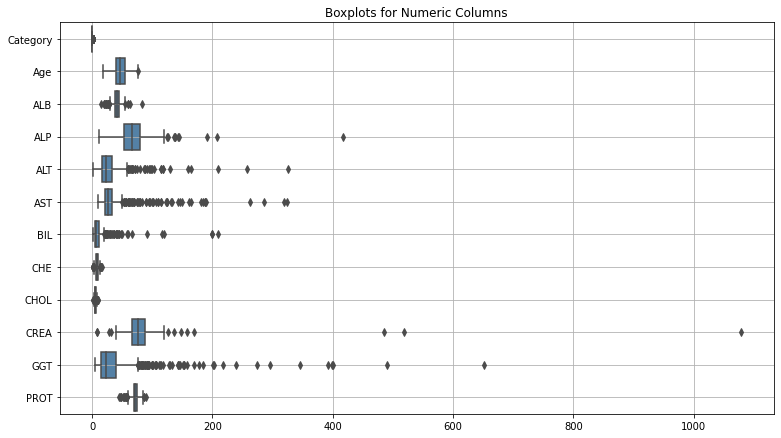

In [12]:
plt.title("Boxplots for Numeric Columns")
sns.boxplot(
    data=df[[col for col in df.columns if np.issubsctype(df[col].dtype, np.number)]],
    orient="h",
    color="steelblue"
)
plt.grid()
plt.show()

In [ ]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.show()

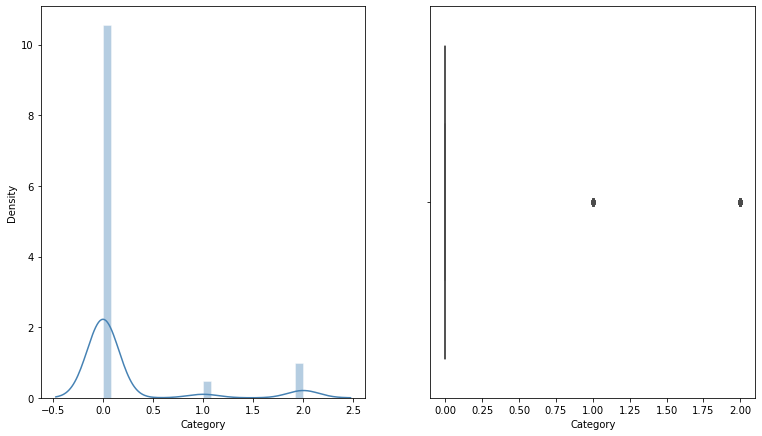

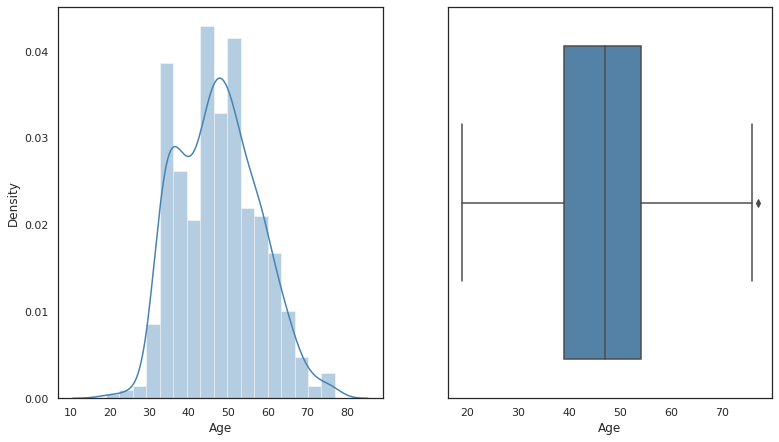

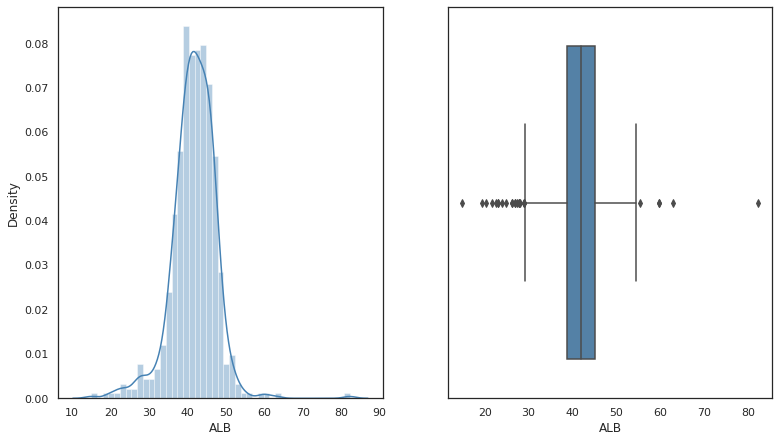

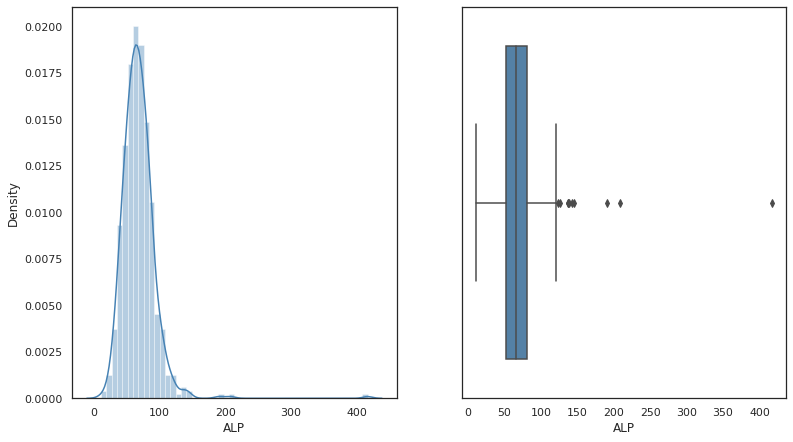

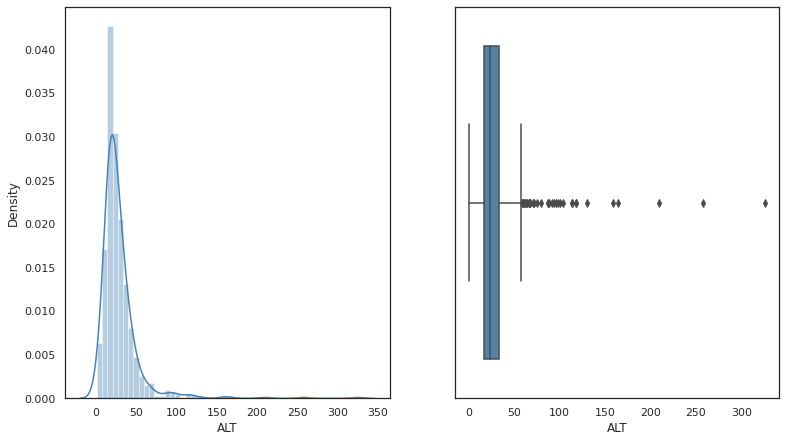

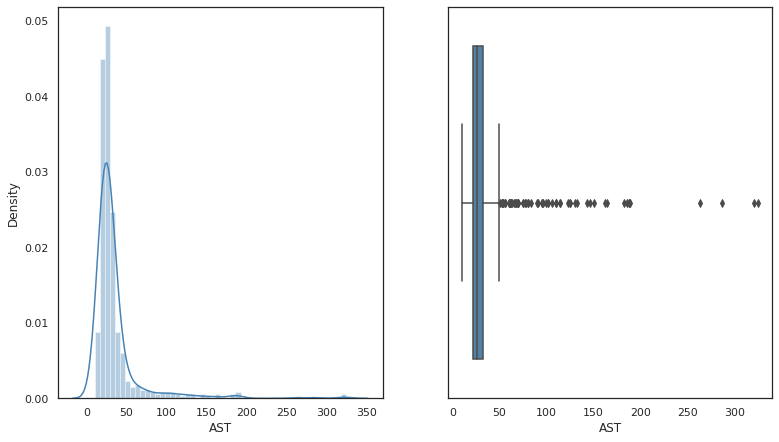

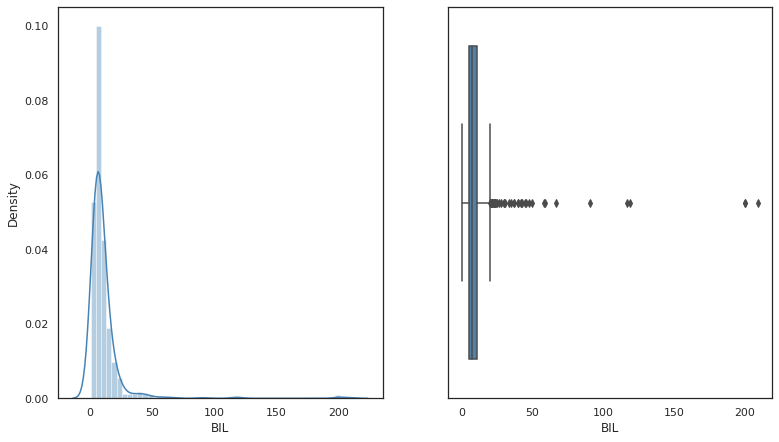

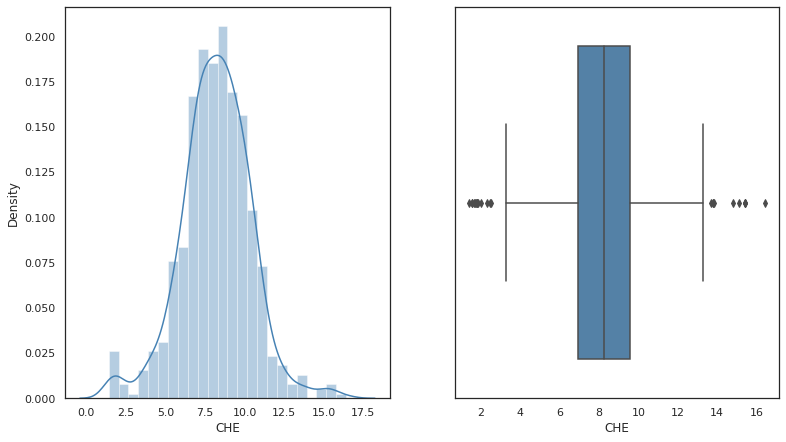

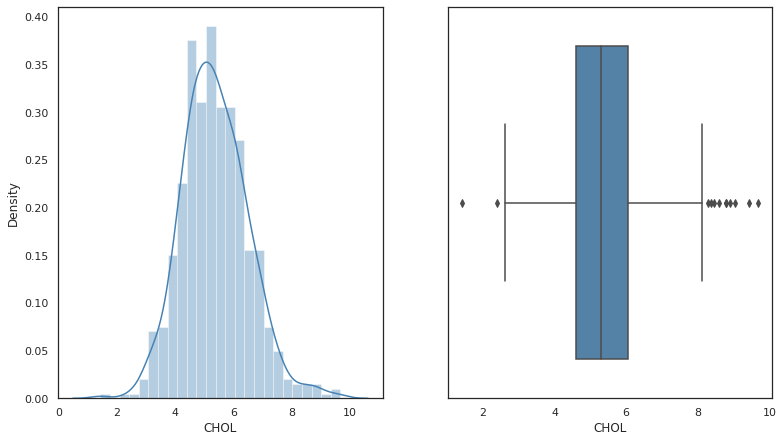

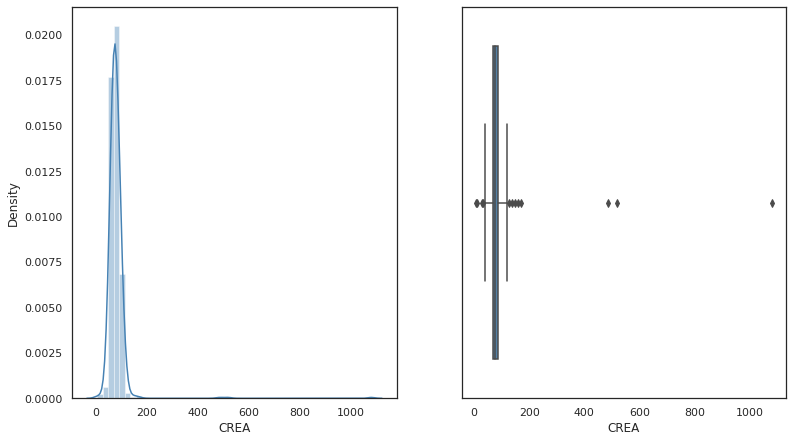

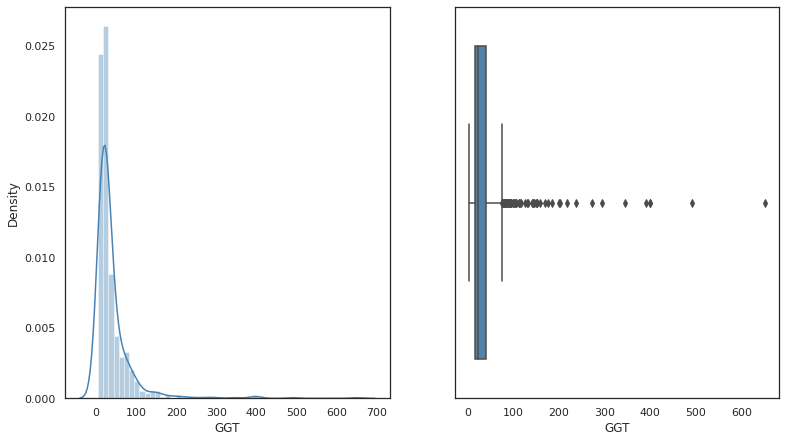

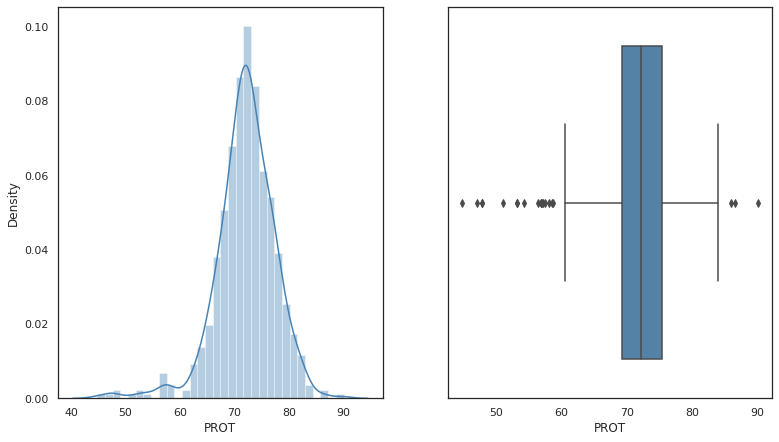

In [13]:
for col in df.columns:
    if np.issubsctype(df[col].dtype, np.number):
        fig, ax = plt.subplots(nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.distplot(x=df[col], ax=ax[0], color="steelblue", kde=True).set_xlabel(f"{col}")
        sns.boxplot(x=df[col], ax=ax[1], color="steelblue").set_xlabel(f"{col}")
plt.show()

In [ ]:
if CLASSIFICATION:
    for col in df.columns:
        if np.issubsctype(df[col].dtype, np.number):
            fig, ax = plt.subplots(nrows=1, ncols=1)
            sns.set(style="white", palette="muted", color_codes=True)
            sns.boxplot(x=y_label, y=col, data=df, color="steelblue")
    plt.show()

In [ ]:
display(df.describe().round(2).T.style.background_gradient(cmap="Blues"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues"))

In [15]:
OVERSAMPLE = ["none", "undersample", "oversample", "combine"][0]
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
col_oe = []
preprocessor_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["no", "yes"]])),
    (MinMaxScaler()),
)
col_ohe = [
    col
    for col in X_train.columns
    if np.issubsctype(X_train[col].dtype, np.object0)
    and col not in col_oe
    and X_train[col].nunique() <= 10
]
preprocessor_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore")),
)
col_num = [
    col for col in X_train.columns if np.issubsctype(X_train[col].dtype, np.number)
]
preprocessor_num = make_pipeline(
    (KNNImputer()),
    (MinMaxScaler()),
)
preprocessor = make_column_transformer(
    (preprocessor_oe, col_oe),
    (preprocessor_ohe, col_ohe),
    (preprocessor_num, col_num),
    sparse_threshold=0
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_oe: {col_oe}")
print(f"col_ohe: {col_ohe}")
print(f"col_num: {col_num}")
print(f"total cols for preprocessor: {len(col_oe) + len(col_ohe) + len(col_num)}")
if CLASSIFICATION:
    if OVERSAMPLE == "undersample":
        X_train_processed, y_train_processed = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy="not minority").fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "oversample":
        X_train_processed, y_train_processed = SMOTE(random_state=RANDOM_STATE, sampling_strategy="not majority").fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "combine":
        X_train_processed, y_train_processed = SMOTEENN(random_state=RANDOM_STATE, sampling_strategy="not majority").fit_resample(X_train_processed, y_train_processed)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0], palette="Blues").set_xlabel("y")
    sns.countplot(y_train, ax=ax[1], palette="Blues").set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2], palette="Blues").set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

-------------------------------------------------------
total na %: 0.35%
-------------------------------------------------------
col_oe: []
col_ohe: ['Sex']
col_num: ['Category', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT']
total cols for preprocessor: 12
-------------------------------------------------------
X: (614, 12)	X_train: (491, 12)	X_train_processed:(491, 12)	X_test: (123, 12)		X_test_processed:(123, 12)
y: (614,)	y_train: (491,)		y_train_processed:(491,)	y_test: (123,)		y_test_processed:(123,)
-------------------------------------------------------


In [ ]:
for col in col_oe + col_ohe:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(x=df[col], ax=ax[0], color="steelblue", hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[1].pie(x=df[col].value_counts(), colors=sns.color_palette("Blues"), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

In [ ]:
if len(col_oe + col_ohe) >= 1 and len(col_num) >= 2:
    sns.lineplot(data=df, x=col_num[0], y=col_num[1], hue=(col_oe + col_ohe)[0])
    plt.title(f"{col_num[0].capitalize()} index with {col_num[1].capitalize()}")
    plt.show()

In [ ]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None)

In [ ]:
# import dtale
# dtale.show(df)
plot(X[col_num], y)

In [16]:
def build_ml_model():
    tests = [
        {
            "model": make_pipeline(
                (preprocessor),
                (SelectPercentile()),
                (RandomForestClassifier()) if CLASSIFICATION else (LinearRegression()),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "randomforestclassifier__n_estimators": [100, 150, 200, 500],
                "randomforestclassifier__criterion": ["gini", "entropy"],
                "randomforestclassifier__max_depth": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_split": [2, 5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_leaf": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__max_features": ["auto", "sqrt", "log2"],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f}"
        )

        plt.subplot(1, 3, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            rscv.predict(X_train),
            rscv.predict(X_train) - y_train,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            rscv.predict(X_test),
            rscv.predict(X_test) - y_test,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()
    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )

def build_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(1, hp.Int("num_layers", min_value=2, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model

def get_result(epochs):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
    )
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f}")
    
        plt.subplot(1, 3, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            model.predict(X_train_processed).T[0],
            model.predict(X_train_processed).T[0] - y_train_processed,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            model.predict(X_test_processed).T[0],
            model.predict(X_test_processed).T[0] - y_test_processed,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model

if SEARCH == "hyperband":
    tuner = Hyperband(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_01 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


2022-04-09 09:30:16.424319: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
%%time
tuner.search(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    callbacks=[early_stop],
    epochs=MAX_TRIALS,
    validation_split=0.2,
    verbose=1,
)
tuner.results_summary()

Trial 30 Complete [00h 00m 02s]
val_mean_squared_error: 103.4683837890625

Best val_mean_squared_error So Far: 29.02900505065918
Total elapsed time: 00h 02m 55s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_00: 160
num_layers: 4
hidden_01: 352
dropout: 0.1
learning_rate: 0.01
hidden_02: 160
hidden_03: 160
hidden_04: 192
hidden_05: 480
hidden_06: 256
hidden_07: 288
hidden_08: 128
hidden_09: 352
hidden_10: 384
hidden_11: 320
hidden_12: 64
hidden_13: 160
hidden_14: 416
hidden_15: 480
hidden_16: 320
hidden_17: 64
hidden_18: 32
hidden_19: 384
hidden_20: 224
hidden_21: 416
hidden_22: 224
hidden_23: 256
hidden_24: 224
hidden_25: 288
hidden_26: 288
hidden_27: 384
hidden_28: 256
hidden_29: 128
hidden_30: 192
hidden_31: 448
hidden_32: 512
hidden_33: 416
hidden_34: 384
hidden_35: 384
hidden_36: 448
hidden_37: 288
hidden_38: 32
hidden_39: 416
hidden_40: 224
hidden_41: 288
hidden_42: 192

Epoch 1/500
7/7 [==============================] - 1s 37ms/step - loss: 3647.6458 - mean_squared_error: 3647.6458 - val_loss: 1848.1692 - val_mean_squared_error: 1848.1692
Epoch 2/500
7/7 [==============================] - 0s 11ms/step - loss: 2893.7134 - mean_squared_error: 2893.7134 - val_loss: 2013.0378 - val_mean_squared_error: 2013.0378
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 982.0399 - mean_squared_error: 982.0399 - val_loss: 128.7473 - val_mean_squared_error: 128.7473
Epoch 4/500
7/7 [==============================] - 0s 11ms/step - loss: 435.0537 - mean_squared_error: 435.0537 - val_loss: 148.3689 - val_mean_squared_error: 148.3689
Epoch 5/500
7/7 [==============================] - 0s 11ms/step - loss: 236.4755 - mean_squared_error: 236.4755 - val_loss: 91.2790 - val_mean_squared_error: 91.2790
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 227.8171 - mean_squared_error: 227.8171 - val_loss: 79.3810 - val_mean_squared_err

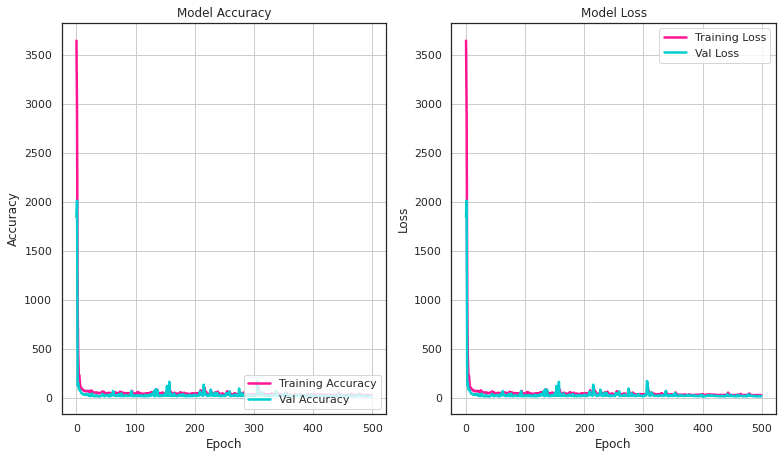

CPU times: user 45.3 s, sys: 5.35 s, total: 50.7 s
Wall time: 37.4 s


In [18]:
%%time
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
)
val_per_epoch = history.history[
    ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
]
best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

plt.subplot(1, 2, 1)
plt.plot(history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color='deeppink', linewidth=2.5)
plt.plot(history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color='darkturquoise', linewidth=2.5)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='deeppink', linewidth=2.5)
plt.plot(history.history["val_loss"], color='darkturquoise', linewidth=2.5)
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Val Loss"], loc="upper right")
plt.grid()
plt.show()

Best epoch: 499
Epoch 1/499
7/7 [==============================] - 1s 36ms/step - loss: 3120.7783 - mean_squared_error: 3120.7783 - val_loss: 1461.7975 - val_mean_squared_error: 1461.7975
Epoch 2/499
7/7 [==============================] - 0s 11ms/step - loss: 1569.9199 - mean_squared_error: 1569.9199 - val_loss: 385.9457 - val_mean_squared_error: 385.9457
Epoch 3/499
7/7 [==============================] - 0s 10ms/step - loss: 503.6495 - mean_squared_error: 503.6495 - val_loss: 587.4581 - val_mean_squared_error: 587.4581
Epoch 4/499
7/7 [==============================] - 0s 11ms/step - loss: 365.4067 - mean_squared_error: 365.4067 - val_loss: 261.9051 - val_mean_squared_error: 261.9051
Epoch 5/499
7/7 [==============================] - 0s 10ms/step - loss: 203.1088 - mean_squared_error: 203.1088 - val_loss: 124.7160 - val_mean_squared_error: 124.7160
Epoch 6/499
7/7 [==============================] - 0s 11ms/step - loss: 146.6457 - mean_squared_error: 146.6457 - val_loss: 69.0226 - val_

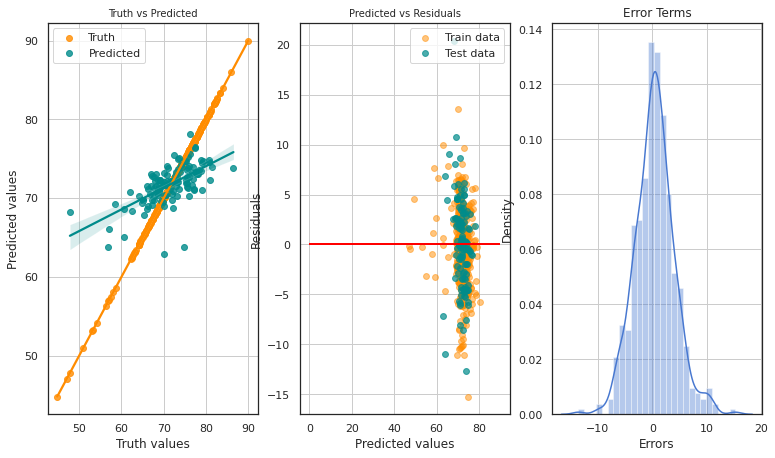

,Truth,Predicted
0,70.1,71.693321
1,70.0,72.089851
2,67.7,71.350281
3,70.7,72.994171
4,81.5,73.979126
5,67.7,69.772011
6,70.7,72.165581
7,77.6,73.157867
8,78.9,74.794998
9,71.9,70.471786


CPU times: user 47.4 s, sys: 5.65 s, total: 53 s
Wall time: 39.7 s


In [19]:
%%time
print(f"Best epoch: {best_epoch}")
model = get_result(best_epoch)

In [20]:
# model = get_result(100)

===train============================
26.08%
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                 normalize='deprecated', positive=False)
{'selectpercentile__score_func': <function f_classif at 0x7f6da3d0c0e0>, 'selectpercentile__percentile': 50, 'columntransformer__pipeline-3__knnimputer__n_neighbors': 9}
===params============================


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectpercentile__score_func,param_selectpercentile__percentile,param_columntransformer__pipeline-3__knnimputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
1,0.048761,0.005766,0.012207,0.000792,<function f_classif at 0x7f6da3d0c0e0>,50,9,{'selectpercentile__score_func': <function f_c...,0.397027,0.100186,0.372763,-0.075505,0.288429,-0.019798,0.337319,0.270838,0.486883,0.449774,0.260792,0.185006,1,0.326557,0.357999,0.329996,0.374387,0.332329,0.351196,0.337417,0.323555,0.315958,0.327093,0.337649,0.017140
6,0.077450,0.042085,0.018826,0.010182,<function f_classif at 0x7f6da3d0c0e0>,60,9,{'selectpercentile__score_func': <function f_c...,0.388608,0.071518,0.404613,-0.066155,0.249195,-0.014137,0.330299,0.213408,0.492802,0.452099,0.252225,0.187678,2,0.327360,0.374440,0.340386,0.374866,0.346871,0.353954,0.341230,0.345591,0.321861,0.330047,0.345661,0.017158
8,0.053849,0.005985,0.016672,0.005466,<function f_classif at 0x7f6da3d0c0e0>,30,3,{'selectpercentile__score_func': <function f_c...,0.418079,0.158897,0.335451,-0.128224,0.285468,-0.106096,0.329841,0.260760,0.495854,0.402819,0.245285,0.201254,3,0.315949,0.341254,0.318196,0.366076,0.328546,0.341073,0.323793,0.320308,0.301066,0.315395,0.327166,0.017298
3,0.059184,0.010005,0.013062,0.002209,<function f_classif at 0x7f6da3d0c0e0>,90,3,{'selectpercentile__score_func': <function f_c...,0.429422,0.017807,0.258802,-0.069897,0.259875,-0.125447,0.334725,0.306354,0.534702,0.478640,0.242498,0.217416,4,0.339668,0.397097,0.360663,0.397968,0.362258,0.379445,0.363696,0.357603,0.341338,0.345925,0.364566,0.019930
0,0.048904,0.006035,0.012170,0.000852,<function f_classif at 0x7f6da3d0c0e0>,90,1,{'selectpercentile__score_func': <function f_c...,0.427154,0.014887,0.263233,-0.062495,0.253041,-0.118414,0.329104,0.303292,0.529214,0.478601,0.241762,0.214211,5,0.337624,0.394594,0.358444,0.394887,0.360492,0.377317,0.362073,0.356194,0.339599,0.343917,0.362514,0.019615
5,0.069775,0.023836,0.015899,0.005298,<function f_classif at 0x7f6da3d0c0e0>,40,3,{'selectpercentile__score_func': <function f_c...,0.393957,0.091415,0.353563,-0.127480,0.286527,-0.113267,0.325247,0.257217,0.498204,0.410696,0.237608,0.205911,6,0.321163,0.343809,0.329430,0.366108,0.328617,0.341421,0.323902,0.320428,0.312950,0.316896,0.330472,0.015147
4,0.056747,0.013553,0.013002,0.001635,<function f_classif at 0x7f6da3d0c0e0>,10,9,{'selectpercentile__score_func': <function f_c...,0.402172,0.190010,0.263365,-0.131406,0.265626,-0.157310,0.279475,-0.027215,0.439270,0.306937,0.183092,0.202624,7,0.266568,0.299107,0.285988,0.324556,0.290493,0.306349,0.289486,0.004067,0.266358,0.287398,0.262037,0.087529
2,0.053411,0.010300,0.015468,0.004744,<function f_classif at 0x7f6da3d0c0e0>,10,3,{'selectpercentile__score_func': <function f_c...,0.400122,0.189825,0.220943,-0.126479,0.265254,-0.153447,0.279075,-0.027223,0.439185,0.306693,0.179395,0.199648,8,0.261776,0.294291,0.285969,0.321014,0.286030,0.301563,0.285029,0.004061,0.262739,0.283478,0.258595,0.086401
7,0.033621,0.008499,0.000000,0.000000,<function chi2 at 0x7f6da3d0c680>,60,5,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.036502,0.012889,0.000000,0.000000,<function chi2 at 0x7f6da3d0c680>,80,5,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===test============================
test score:46.19%
====end===========================

Running DummyRegressor()
r2: -0.009 neg_mean_squared_error: -29.238
=== new best DummyRegressor() (using r2):
r2: -0.009 neg_mean_squared_error: -29.238

Running DecisionTreeRegressor(max_depth=1)
r2: 0.095 neg_mean_squared_error: -25.475
=== new best DecisionTreeRegressor(max_depth=1) (using r2):
r2: 0.095 neg_mean_squared_error: -25.475

Running DecisionTreeRegressor(max_depth=5)
r2: 0.114 neg_mean_squared_error: -24.800
=== new best DecisionTreeRegressor(max_depth=5) (using r2):
r2: 0.114 neg_mean_squared_error: -24.800

Running Ridge(alpha=10)
r2: 0.299 neg_mean_squared_error: -19.460
=== new best Ridge(alpha=10) (using r2):
r2: 0.299 neg_mean_squared_error: -19.460

Running Lasso(alpha=10)
r2: -0.009 neg_mean_squared_error: -29.238

Best model:
Ridge(alpha=10)
Best Scores:
r2: 0.299 neg_mean_squared_error: -19.460
-------------------------------------------------------
r2: 0.462 neg_mean_squa

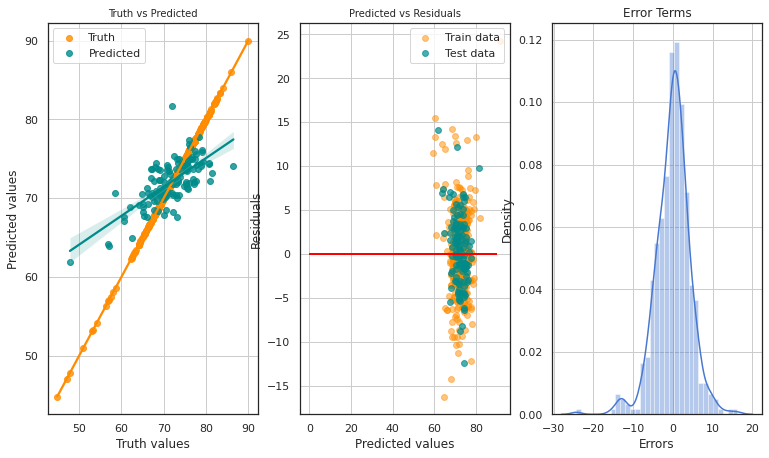

,Truth,Predicted
0,70.1,72.1
1,70.0,71.4
2,67.7,70.4
3,70.7,73.6
4,81.5,73.2
5,67.7,68.5
6,70.7,70.4
7,77.6,75.5
8,78.9,74.0
9,71.9,81.7


In [21]:
build_ml_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 160)               2080      
_________________________________________________________________
dense_13 (Dense)             (None, 352)               56672     
_________________________________________________________________
dropout_8 (Dropout)          (None, 352)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 160)               56480     
_________________________________________________________________
dropout_9 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 160)               25760     
_________________________________________________________________
dropout_10 (Dropout)         (None, 160)              

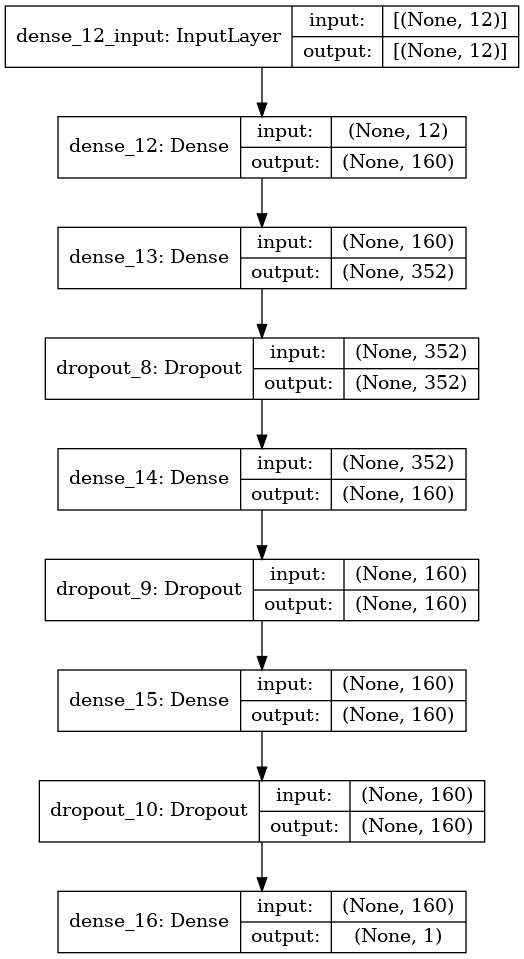

In [22]:
model.summary()
plot_model(model, show_shapes=True)

In [23]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"dl_preprocessor.pkl", "wb"))

2022-04-09 09:34:36.483885: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [24]:
# import shutil
# from pickle import load

# import pandas as pd
# from tensorflow import keras

# df = pd.DataFrame(
#     {
#         "": [],
#         "": [],
#     }
# )
# shutil.unpack_archive("dl_model.zip", "dl_model")
# preprocessor = load(open("dl_preprocessor/dl_preprocessor.pkl", "rb"))
# model = keras.models.load_model("dl_model")
# model.predict(preprocessor.transform(df))
